In [1]:
#from math import sqrt

#import fastai
from copy import deepcopy
from timeit import default_timer as timer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix # sparse matrix

from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
DPI = 120

In [2]:
raw_data = pd.read_csv("old_data/raw_metacritic_game_user_comments.csv")
game_info_data = pd.read_csv("src/data/game_info.csv")
train_data = pd.read_csv("src/data/user_data_train_no_comments.csv")
test_data = pd.read_csv("src/data/user_data_test_no_comments.csv")
valid_data = pd.read_csv("src/data/user_data_validation_no_comments.csv")

game_info_data = game_info_data.rename(columns={"Unnamed: 0" : "Id"})

In [3]:
all_data = pd.concat([train_data, test_data, valid_data], ignore_index=True)
#all_data = pd.concat([train_data, test_data, valid_data])

In [4]:
#game_info_data
all_data

,Unnamed: 0,Userscore,Username,Game_ID
0,47246,9,SergeantSoz,119
1,199743,9,SergeantSoz,1540
2,235823,8,SergeantSoz,2227
3,263595,8,SergeantSoz,2941
4,72338,9,tomcrew10,238
...,...,...,...,...
151992,242135,10,AlexN.,2375
151993,258319,9,AlexN.,2834
151994,17628,9,zenmechanic,33
151995,32734,8,zenmechanic,70


In [5]:
# transform usernames into user IDs
user_to_id_map = {}
for i, username in enumerate(np.unique(all_data["Username"])):
    user_to_id_map[username] = i

In [6]:
def format_data(data, usermap):
    # replaces usernames with numeric IDs
    user_ids = []
    for user in data["Username"]:
        user_ids.append(user_to_id_map[user])
    #print(user_ids)
    #for i in range(len(data)):
    #for i in range(len(data)):
    #    data["Username"][i] = user_to_id_map[data["Username"][i]]
        
    #fmt = data["Username"].astype(int)
    data.insert(4, "User_ID", user_ids, allow_duplicates=True)
    data = data.drop(["Unnamed: 0"], axis=1)
    return data

In [7]:
#print(all_data.loc[16220])
#print(all_data["Username"][1])
all_data = format_data(all_data, user_to_id_map)
train_data = format_data(train_data, user_to_id_map)
test_data = format_data(test_data, user_to_id_map)
valid_data = format_data(valid_data, user_to_id_map)

In [8]:
valid_data

,Userscore,Username,Game_ID,User_ID
0,3,AlanG.,474,471
1,10,AlanG.,532,471
2,9,AlanG.,532,471
3,9,AlanG.,1525,471
4,10,TonyM.,20,14243
...,...,...,...,...
14913,10,AlexN.,2375,538
14914,9,AlexN.,2834,538
14915,9,zenmechanic,33,22017
14916,8,zenmechanic,70,22017


In [9]:
n_users = len(np.unique(all_data["Username"]))
n_games = len(game_info_data)

#print(len(np.unique((pd.concat([train_data, test_data, valid_data]))["Username"])))
#print(len(np.unique(train_data["Username"]))
#      + len(np.unique(valid_data["Username"]))
#      + len(np.unique(test_data["Username"])))

def group_data(data, label):
    """
    dict that maps label -> dataframe
    """
    return dict(tuple(data.groupby(label))) # default sort=True

# map: user -> np.array of game indices
user_game_idx = group_data(all_data, "User_ID")
for key in user_game_idx:
    user_game_idx[key] = user_game_idx[key]["Game_ID"].to_numpy()

# map: game -> np.array of user indices
game_user_idx = group_data(all_data, "Game_ID")
for key in game_user_idx:
    game_user_idx[key] = game_user_idx[key]["User_ID"].to_numpy()

In [10]:
print(f"users: {n_users}")
print(f"games: {n_games}")

users: 22072
games: 5000


In [11]:
# data class
def np_rand(size, min_i, max_i, rs):
    array = rs.random_sample(size)
    array *= (max_i - min_i)
    array += min_i
    return array

class EmbeddingsIndex:
    def __init__(self, data):
        self.user_idx = data["User_ID"].to_numpy()
        self.game_idx = data["Game_ID"].to_numpy()
        
        self.embed_scores = csr_matrix((data["Userscore"].to_numpy(),
                                       (self.user_idx, self.game_idx)),
                                       shape=(n_users, n_games), dtype=np.int8)
        
        self.unique_user_idx = np.sort(np.unique(data["User_ID"]))
        self.unique_game_idx = np.sort(np.unique(data["Game_ID"]))

        ## map: user -> np.array of game indices
        #self.user_game_idx = group_data(data, "User_ID")
        #for key in self.user_game_idx:
        #    self.user_game_idx[key] = self.user_game_idx[key]["Game_ID"].to_numpy()

        ## map: game -> np.array of user indices
        #self.game_user_idx = group_data(data, "Game_ID")
        #for key in self.game_user_idx:
        #    self.game_user_idx[key] = self.game_user_idx[key]["User_ID"].to_numpy()


class Embeddings:
    """
    requires transformation of data:
    all values must be non-negative to properly maintain bounds
    TODO experiment with non-negativity
    """
    def __init__(self, embed_dim, n_users, n_games, n_range, seed):
        rs = RandomState(MT19937(SeedSequence(seed)))

        # assumes first element is 0 lol
        # TODO change
        min_n = 0
        #max_n = (3 / (2 + embed_dim))
        max_n = 2

        #min_n = (1 / (n_range[0] + embed_dim))
        #max_n = (1 / (n_range[1] + embed_dim))

        #min_n = n_range[0]
        #max_n = n_range[1]

        self.bias_users = np_rand(n_users, min_n, max_n, rs)
        self.bias_games = np_rand(n_games, min_n, max_n, rs)

        self.embed_users = np_rand((n_users, embed_dim), min_n, max_n, rs)
        self.embed_games = np_rand((n_games, embed_dim), min_n, max_n, rs)

        #self.user_idx = all_data["User_ID"].to_numpy()
        #self.game_idx = all_data["Game_ID"].to_numpy()
        #
        #self.embed_scores = csr_matrix((all_data["Userscore"].to_numpy(),
        #                               (self.user_idx, self.game_idx)),
        #                               shape=(n_users, n_games), dtype=np.int8)

    def calc_preds(self, ei):
        # dot product
        preds = np.sum(e.embed_users[ei.user_idx] * e.embed_users[ei.game_idx], axis=1)
        # add bias of the game and user
        preds = preds + e.bias_users[ei.user_idx] + e.bias_games[ei.game_idx]
        return preds
    
    def calc_preds_single(self, user_id, game_id):
        pred = np.dot(e.embed_users[user_id], e.embed_users[game_id])
        # add bias of the game and user
        pred = pred + e.bias_users[user_id] + e.bias_games[game_id]
        return pred
        
    def calc_preds_sparse(self, ei):
        preds = self.calc_preds(ei)
        preds_matx = csr_matrix((preds, (ei.user_idx, ei.game_idx)),
                                shape=(n_users, n_games), dtype=np.float64)
        
        return preds_matx
    
        #sub = preds_matx - e.embed_scores

In [12]:
ei_all = EmbeddingsIndex(all_data)
ei_train = EmbeddingsIndex(train_data)
ei_test = EmbeddingsIndex(test_data)
ei_valid = EmbeddingsIndex(valid_data)

In [49]:
class EmbeddingMatricesModel:
    def __init__(self, e):
        self.e = e
        
    def train(self, ei, alpha, cycles=1):
        for _ in range(cycles):
            self._train(ei, alpha)
        
    def _train(self, ei, alpha):
        # copies embeddings to use and then throw away later
        #e_temp = deepcopy(e) # UNTESTED ASSUMPTION: this deepcopy works, TODO!

        # preds - score in a sparse array
        diff_matx = self.e.calc_preds_sparse(ei) - ei.embed_scores
        #print(e_temp.calc_preds_sparse(ei))

        #### gradient descent ####
        # sum for each user / game
        grad_bias_user = alpha * 2 * np.squeeze(np.asarray(np.sum(diff_matx, axis=1)))
        grad_bias_game = alpha * 2 * np.squeeze(np.asarray(np.sum(diff_matx, axis=0)))

        #grad_embed_user = self._grad_user_game(ei.user_game_idx, "user", diff_matx, alpha)
        #grad_embed_game = self._grad_user_game(ei.game_user_idx, "game", diff_matx, alpha)

        grad_embed_user = []
        # inefficient for loop, oh well
        for user in ei.unique_user_idx:
            # n_g = number of games the user reviewed
            n_g = len(user_game_idx[user])

            # indexes the user review scores (pred - actual) from the difference matrix
            diff_matx_idx = diff_matx[np.full(n_g, user), user_game_idx[user]]
            #diff_matx_idx = diff_matx[user_game_idx[user], np.full(n_g, user)]

            # multiplies each used game vector by the score_diff
            used_game_vecs = self.e.embed_games[user_game_idx[user]]
            mult = used_game_vecs * np.asarray(diff_matx_idx).T

            # sums along the embedding dimension
            grad_embed_user_vec = alpha * 2 * np.sum(mult, axis=0)

            grad_embed_user.append(grad_embed_user_vec)

        grad_embed_game = []
        for game in ei.unique_game_idx:
            # n_u = number of unique users that the game has reviews from
            n_u = len(game_user_idx[game])

            # indexes the user review scores (pred - actual) from the difference matrix
            diff_matx_idx = diff_matx[game_user_idx[game], np.full(n_u, game)]
            #diff_matx_idx = diff_matx[game_user_idx[game], np.full(n_u, game)]

            # multiplies each used game vector by the score_diff
            used_user_vecs = self.e.embed_users[game_user_idx[game]]
            mult = used_user_vecs * np.asarray(diff_matx_idx).T

            # sums along the embedding dimension
            grad_embed_game_vec = alpha * 2 * np.sum(mult, axis=0)

            grad_embed_game.append(grad_embed_game_vec)


        grad_embed_user = np.array(grad_embed_user)
        grad_embed_game = np.array(grad_embed_game)
        
        e.bias_users = e.bias_users - grad_bias_user       
        e.bias_games = e.bias_games - grad_bias_game
        e.embed_users[ei.unique_user_idx] = e.embed_users[ei.unique_user_idx] - grad_embed_user
        e.embed_games[ei.unique_game_idx] = e.embed_games[ei.unique_game_idx] - grad_embed_game
        
        #print(diff_matx)
        #print(grad_bias_user.shape)
        #print(grad_bias_game.shape)
        #print(grad_embed_user.shape)
        #print(grad_embed_game.shape)
    
    def predict(self, data, ei, alpha, cycles=1):
        old_e = deepcopy(self.e)
        #extra = []
        preds = []
        actual = []
        #times = []

        start = timer()
        for user_id in ei.unique_user_idx:
            # ASSUMPTION: user is completely unique and has not been trained on,
            # thus we can use the global var user_game_idx

            user_data = data[data["User_ID"] == user_id]

            user_start = timer()
            for i, game_id in enumerate(user_data["Game_ID"]):
                #print(i, game_id)
                #print(i, game_id)
                user_data_drop = user_data.drop(user_data.index[[i]])
                temp_ei = EmbeddingsIndex(user_data_drop)
                self.train(temp_ei, alpha, cycles=cycles)
                
                # predicts final value
                pred = self.e.calc_preds_single(user_id, game_id)
                preds.append(pred)
                actual.append(ei_all.embed_scores[user_id, game_id])
                #extra.append((user_id, game_id))
                #self.e.embed_users[user_id] + self.e.embed_users[user_id]
                
                # resets embeddings
                #self.e.bias_users = np.copy(old_e.bias_users)
                #self.e.bias_games = np.copy(old_e.bias_games)
                #self.e.embed_users = np.copy(old_e.embed_users)
                #self.e.embed_games = np.copy(old_e.embed_games)
                
                # ASSUMPTION: deepcopy is done here
                self.e.bias_users[user_id] = old_e.bias_users[user_id]
                self.e.bias_games[temp_ei.game_idx] = old_e.bias_games[temp_ei.game_idx]
                self.e.embed_users[user_id] = old_e.embed_users[user_id]
                self.e.embed_games[temp_ei.game_idx] = old_e.embed_games[temp_ei.game_idx]
                
                #print(user_data_drop)
                #break
            #break
            user_end = timer()
            #times.append(user_end - user_start)
            print(user_end - user_start)

        end = timer()
        print("global time:", end - start)
            
        preds = np.array(preds)
        actual = np.array(actual)
        
        return preds, actual
        # fold in new data

# data batches?

#def train(e, cycles=1):
#    pass

In [50]:
# hyperparameters
embed_dim = 5
#range_min = -1
#range_max = 11
n_range = (-1, 11)
seed = 69
cycles = 3
alpha = 0.1

e = Embeddings(embed_dim, n_users, n_games, n_range, seed)

In [51]:
model = EmbeddingMatricesModel(e)

In [52]:
model.train(ei_train, alpha=alpha, cycles=cycles)

In [54]:
preds, actual = model.predict(test_data, ei_test, alpha=alpha, cycles=0)

0.03307795801083557
0.002646701002959162
0.0022284660080913454
0.0066006259876303375
0.0023077460064087063
0.0030240699998103082
0.002096878000884317
0.008476640010485426
0.00229166800272651
0.0029525810095947236
0.0036324980028439313
0.003969926998252049
0.0029378189938142896
0.0022369880025507882
0.0035175109951524064
0.0035437759943306446
0.0022236220102058724
0.0021004430018365383
0.0022822019964223728
0.029053017002297565
0.026128900004550815
0.008101767001789995
0.0029713779949815944
0.0035725549969356507
0.002210256992839277
0.0021276210027281195
0.006998953002039343
0.002904175009462051
0.008202015000279061
0.002824305003741756
0.002100001001963392
0.002139806005288847
0.0021115779964020476
0.0024624439975013956
0.002727466999203898
0.0027065129979746416
0.0024638709874125198
0.005788489987025969
0.008929891992011108
0.00819812499685213
0.005764020999777131
0.002414806993328966
0.0022647159930784255
0.0033444180007791147
0.008703879997483455
0.007771083997795358
0.0023651400115

(array([4.313e+03, 7.300e+01, 1.500e+01, 5.000e+00, 5.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00]),
 array([0.0022337, 0.0239829, 0.0457321, 0.0674813, 0.0892305, 0.1109797,
        0.1327289, 0.1544781, 0.1762273, 0.1979765, 0.2197257]),
 <BarContainer object of 10 artists>)

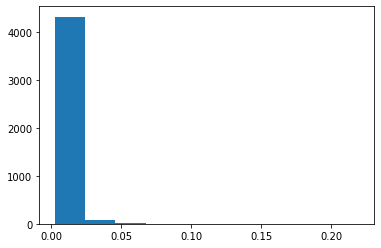

In [137]:
#plt.hist(user_times)

In [139]:
mean_squared_error(preds, actual, squared=False)

4.660925873790532

In [81]:
user_game_idx[5]

array([  71,  126,  254,  276,  447,  501,  565,  607,  623,  731,  771,
        792, 1196, 1214, 1525, 1666, 2169, 2331, 2690, 2797, 2854, 2910,
       2924, 3044, 3389])

In [82]:
test_data[test_data["User_ID"] == 5]

,Userscore,Username,Game_ID,User_ID
22709,9,0235,71,5
22710,10,0235,126,5
22711,8,0235,254,5
22712,7,0235,276,5
22713,9,0235,447,5
22714,6,0235,501,5
22715,7,0235,565,5
22716,9,0235,607,5
22717,3,0235,623,5
22718,5,0235,731,5


In [45]:
#ei_all = EmbeddingsIndex(all_data)
print(len(e.embed_users[ei_all.user_idx]))
print(len(e.embed_users[ei_all.game_idx]))
# dot products of all
#np.sum(e.embed_users[e.user_idx] * e.embed_users[e.game_idx], axis=1)

151997
151997


In [323]:
#embed_users
e.calc_preds_sparse(ei_all)

[0.04315262 0.04981189 0.04130281 ... 0.01157442 0.01063349 0.01732781]
hello


<22072x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 150678 stored elements in Compressed Sparse Row format>

In [271]:
# basic for loop: train?
temp_users = np.copy(e.embed_users)
temp_games = np.copy(e.embed_games)

#for game_idx in game_user_idx:
#    e.
#e.embed_users[0] = np.array([1 , 0.14144417, 0.10577846, 0.11545083, 0.06428982])
#temp_users[game_user_idx[0]]

#user_game_idx[0] : user 0 reviews [g_1, g_2, ... g_k] games
#temp_games[user_game_idx[1]]
#temp_games[user_game_idx[1]] * np.array([1, 2, 3]).reshape((3, 1))
#temp_games[user_game_idx[1]] * np.expand_dims(np.array([1, 2, 3]), axis=0)

user_game_n = len(user_game_idx[1])
# scores - pred, sparse
difference_matx = e.embed_scores - e.calc_preds_sparse()
# [user_idx, user_idx, ...] and [game_1, game_2, ...]
diff_matx_user_1 = difference_matx[np.full(user_game_n, 1), user_game_idx[1]]
#print(embed_scores_user_1)

# all game embedded vectors * the scores
mult = temp_games[user_game_idx[1]] * np.asarray(diff_matx_user_1).T
np.sum(mult, axis=0)


array([1.11850109, 1.90066312, 1.04051874, 3.01521198, 1.93910193])

In [273]:
difference_matx

<22072x5000 sparse matrix of type '<class 'numpy.int8'>'
	with 144225 stored elements in Compressed Sparse Row format>

In [241]:
temp_games[user_game_idx[1]] * np.asarray(embed_scores_user_1).T

array([[1.31403366, 1.51841435, 1.32498256, 0.65024934, 1.12424214],
       [1.59827313, 0.57381002, 1.29401492, 0.72905711, 1.13623971],
       [1.01113591, 1.07838738, 1.37950324, 0.71855202, 0.87313254]])

In [191]:
e.embed_scores[[4192, 3073], [0, 0]]

matrix([[10, 10]], dtype=int8)

In [198]:
#game_user_idx
np.array(list(user_game_idx.values()))

array([array([  87, 1140, 1478, 1538, 2241, 2278, 2461, 3400]),
       array([ 288, 1269, 1835]),
       array([  56,  195,  390,  796,  853, 1549, 2982]), ...,
       array([  93, 1024, 1134, 1829, 3201]), array([  21,  792, 1054]),
       array([ 263,  724,  995, 1022])], dtype=object)

In [112]:
sub_test = test - e.embed_scores

In [134]:
np.squeeze(np.asarray(np.sum(sub_test, axis=0)))
#np.squeeze(np.asarray(np.sum(sub_test, axis=1)))

array([-6512,  1969, 14305, ...,     0,     0,     0])

In [163]:
#e.embed_users * e.embed_games
(e.embed_users[e.user_idx] * e.embed_games[e.game_idx]).shape
#len(e.embed_users[e.user_idx] * e.embed_games[e.game_idx])
#(e.embed_users[e.user_idx] * e.embed_games[e.game_idx])

(151997, 5)

In [148]:
np.array([[1, 2],
          [3, 4, 5]])

array([list([1, 2]), list([3, 4, 5])], dtype=object)

In [308]:
ei_train.user_idx
ei_train.game_idx

array([ 119, 1540, 2227, ..., 1063, 2137, 2944])

In [41]:

bruh = np.array([[1, 2],
                 [3, 4],
                 [5, 6]])

In [42]:
bruh[[0,2], :]
#bruh[[0,2], :] = np.array([[10, 20],
#                           [50, 60]])
bruh[[0,2], :] = bruh[[0,2], :] + np.array([[10, 10],
                                            [10, 10]])
#bruh[0, 2] = np.array([[1, 2],
#                       [5, 6]])

In [43]:
bruh

array([[11, 12],
       [ 3,  4],
       [15, 16]])